**NER**

In [3]:
#pip install neuralprophet

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta
from neuralprophet import NeuralProphet


import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [13]:
# raot_cta_ner = pd.read_csv('ner_data.csv')
raot_cta_ner = pd.read_csv('cta_ner_standard_deviation_msa_up_to_date.csv')
print(raot_cta_ner['PROPERTY_ID'].nunique())
raot_cta_ner.head()

11998


,WEEK_START,PROPERTY_ID,SURVEY_ID,SURVEY_DATE,STATE,STATE_ID,MSA,MSA_ID,SUBMARKET,SUBMARKET_ID,NER,NER_T4,UNITS,UNITS_T4
0,2019-06-10,5c952d95c401700015e59ab2,5d041324ca44d400152b657b,2019-06-14,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Dallas, TX",62eb1840-3fe2-8049-5062-9646e18700e4,Northeast,20962d6bfb4c87e5593d2f3bff5e2f99,1357.640264,1329.476072,303.0,303.0
1,2014-09-15,5642c17655d27c0e003b5ae8,5642c1ce55d27c0e003b8820,2014-09-15,California,3e5ffbdd-4051-7165-7db7-21bdd14930db,"Sacramento, CA",a2a9af91-964e-a267-9046-91d8c6ed645a,Other,5414f19e0902eb35626ffd051c9249af,1498.000000,1534.078947,171.0,171.0
2,2015-02-02,568b4caeeb46290e00ffb7c3,568b4eeb0406580e009c4f65,2015-02-02,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Houston, TX",5808a3f7-45f6-467e-864b-5e0f0e4a0cc1,Montrose/River Oaks,d8ac5f933b79217ff383d337fed58ee1,1710.047318,1710.047318,317.0,317.0
3,2019-12-02,5d85015fa8f87e001d7ceacf,5de558ef6e028b001da8ba45,2019-12-02,Colorado,d611adb9-a2fe-1a3a-63e5-1d8634942efa,"Denver, CO",f6c8f11a-8783-573a-8140-6f221f077529,Denver-South/Glendale,9898e672265aac9197cf49878fa0b453,1824.636363,1843.041817,275.0,275.0
4,2018-07-23,5642c18855d27c0e003b6fa6,5b56088c502f3c001307765a,2018-07-23,Arizona,60682b07-6de7-18cc-618b-dfd375ec2200,"Phoenix, AZ",3593fab5-48d8-741f-9eeb-16a13099553c,North Scottsdale/Fountain Hills,9fd2c103c3304388edf88dfa14f5f4db,1104.527272,1104.527272,330.0,330.0


In [14]:
raot_cta_ner['WEEK_START'] = pd.to_datetime(raot_cta_ner['SURVEY_DATE']).dt.date
raot_cta_ner = raot_cta_ner.sort_values(by='WEEK_START')

# select rows where date is between given start/end date (inclusive)
start_date = pd.to_datetime('1/1/2015')
end_date =  pd.to_datetime('10/09/2022')

raot_cta_ner = raot_cta_ner.loc[
    (raot_cta_ner['WEEK_START'] >= start_date) & (raot_cta_ner['WEEK_START'] <= end_date)]

In [15]:
def start_week_date(survey_date):
    start_date = survey_date - timedelta(days=survey_date.weekday())
    
    return start_date

raot_cta_ner['WEEK_START'] = raot_cta_ner.apply(lambda x: start_week_date(x['WEEK_START']), axis=1)
raot_cta_ner.tail()

,WEEK_START,PROPERTY_ID,SURVEY_ID,SURVEY_DATE,STATE,STATE_ID,MSA,MSA_ID,SUBMARKET,SUBMARKET_ID,NER,NER_T4,UNITS,UNITS_T4
419356,2022-10-03,61bc8c253eb983002a3df742,63431774c008895a8abeed04,2022-10-09,Oklahoma,f558bb7f-6cec-5f40-73ee-4794adfd38c4,"Tulsa, OK",d0cca12e-9d37-6f6a-6d28-6b7843b4516c,South,94ea44d954d2d24ccf5fc500a96e0cee,736.783606,736.783606,305.0,305.0
10149,2022-10-03,5d69844e32fa94001dab46a8,6343035df4fbb65edac09950,2022-10-09,California,3e5ffbdd-4051-7165-7db7-21bdd14930db,"San Diego, CA",dfad4dd3-9313-6c18-50c1-0de9821b0d67,Downtown San Diego,64cd135117aa06404f9aae45d094e97d,3331.192488,3338.811619,426.0,426.0
507438,2022-10-03,5ce2d8145e5ddc00154f6aba,6342afacbe45b2160620ae6d,2022-10-09,Colorado,d611adb9-a2fe-1a3a-63e5-1d8634942efa,"Denver, CO",f6c8f11a-8783-573a-8140-6f221f077529,Aurora-South,96faed51c8be20004c7e485032facf96,1970.625000,1962.460647,216.0,216.0
672386,2022-10-03,5ec7cb3c31f7d70004c3e4b0,634304c1399b0a32501c8c7d,2022-10-09,Washington,29f94770-3b3e-9adc-491b-dd6422b92859,"Seattle, WA",673ebf82-2936-9c7e-1c0c-26b22ba92f0c,Everett/Mukilteo/Mill Creek,be03b445c4543ca90eebb728d573db82,2046.693002,2046.693002,443.0,443.0
804142,2022-10-03,577fdb996b930c0e009f0e74,634215d36516178da78f2068,2022-10-09,Nevada,ebf21ea4-8547-91a2-687b-b996dd6144ec,"Las Vegas, NV",389103f2-0f79-8743-35e7-38e657fe8f0d,Henderson/Southeast,735620776fd30a84dade8cdcd36d0fc4,1581.160000,1552.029999,600.0,600.0


In [16]:
raot_cta_ner = raot_cta_ner[['WEEK_START', 'PROPERTY_ID', 'STATE', 'MSA', 'SUBMARKET', 'NER_T4', 'UNITS_T4']]

In [17]:
from prophet import Prophet
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [18]:
class NeuralProphetModel:
    def __init__(self, algorithm_name, prediction_period):
        self.algorithm_name = algorithm_name
        self.prediction_period = prediction_period
        self.model = NeuralProphet()
        
    def transformation(self, data, time_col, target_col):
        data[time_col] = pd.to_datetime(data[time_col])
        data.rename(columns={time_col:'ds', target_col:'y'}, inplace=True)
        
        data.drop(data.columns.difference(['ds','y']), 1, inplace=True)

        train_data = data[:-self.prediction_period]
        test_data = data[-self.prediction_period:]
        
        return train_data, test_data
            
    def fit_model(self, train_data):
        self.model.fit(train_data, freq="w")
        return self.model
        
    def predict(self, train_data):
        future_data = self.model.make_future_dataframe(train_data, periods=self.prediction_period, n_historic_predictions=0)
        forecast = self.model.predict(future_data)
        predictions = forecast[['ds', 'yhat1']]
        return predictions
    
    def evaluation(self, test_data, predictions):
        mae = mean_absolute_error(predictions['yhat1'], test_data['y'])
        print("mean_absolute_error on testing set:", mae)
        
        mape = mean_absolute_percentage_error(predictions['yhat1'], test_data['y'])
        print("mean_absolute_percentage_error on testing set:", mape)

        r_squared = r2_score(predictions['yhat1'], test_data['y'])
        print("r2_score on testing set:", r_squared)
        
        return mape
    
    def plot(self, test_data, predictions, label):
        plt.figure(figsize=(10, 5))
        plt.plot(test_data['ds'], test_data['y'], label = 'real data')
        plt.plot(predictions['ds'], predictions['yhat1'], label = 'predictions')
        plt.legend()
        plt.title(f'Forecast vs Actuals for {label} with an error of {round(self.evaluation(test_data, predictions),3)}%')
        plt.show()
        
        return None

    def save_model(self, filename):    
        pickle.dump(self.model, open(filename, 'wb'))

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.738% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 273


  0%|          | 0/117 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.42E-02, min: 1.96E+00


  0%|          | 0/117 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.42E-02, min: 2.81E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.61E-02
Epoch[273/273]: 100%|██████████| 273/273 [00:11<00:00, 22.99it/s, SmoothL1Loss=0.00212, MAE=27.2, RMSE=35.2, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.738% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 144.0723953233884
mean_absolute_percentage_error on testing set: 0.06784450432592797
r2_score on testing set: -4.827166694929507
mean_absolute_error on testing set: 144.0723953233884
mean_absolute_percentage_error on testing set: 0.06784450432592797
r2_score on testing set: -4.827166694929507


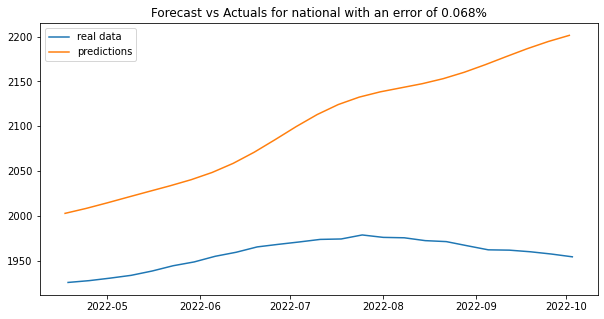

In [19]:
if __name__ == '__main__':
    avg_ner_data = raot_cta_ner.groupby(['WEEK_START']).agg({'UNITS_T4':'sum','NER_T4':'mean'}).reset_index()

    ## experimenting with a dataset
    prediction_period = 25
    algorithm_name = 'Neural Prophet Model'
    
    results = NeuralProphetModel(algorithm_name, prediction_period)
    df_train, df_test = results.transformation(avg_ner_data, 'WEEK_START', 'NER_T4')
    results.fit_model(df_train)
    predictions = results.predict(df_train)
    results.evaluation(df_test, predictions)
    results.plot(df_test, predictions, 'national')

# MSA Level

In [20]:
msa_data = pd.read_csv('msa_data.csv')
msa_data_lst = list(msa_data['MSA'])

subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER_T4').reset_index()

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.201% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 313


  0%|          | 0/114 [00:00<?, ?it/s]

Atlanta, GA


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.83E-02, min: 4.08E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.83E-02, min: 4.08E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.50E-02
Epoch[313/313]: 100%|██████████| 313/313 [00:10<00:00, 30.53it/s, SmoothL1Loss=0.00237, MAE=51.4, RMSE=67.8, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.201% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 193.2973934607166
mean_absolute_percentage_error on testing set: 0.09585400318895947
r2_score on testing set: -9.350813727814097
mean_absolute_error on testing set: 193.2973934607166
mean_absolute_percentage_error on testing set: 0.09585400318895947
r2_score on testing set: -9.350813727814097


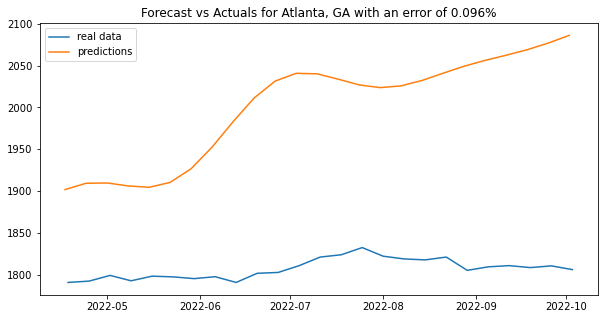

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.038% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 297


  0%|          | 0/115 [00:00<?, ?it/s]

Austin, TX


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.07E-01, min: 2.98E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.13E-01, min: 4.03E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.20E-01
Epoch[297/297]: 100%|██████████| 297/297 [00:10<00:00, 28.92it/s, SmoothL1Loss=0.00284, MAE=46.5, RMSE=68.2, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.038% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 141.30007827967628
mean_absolute_percentage_error on testing set: 0.07659535948735158
r2_score on testing set: -4.6763673155724765
mean_absolute_error on testing set: 141.30007827967628
mean_absolute_percentage_error on testing set: 0.07659535948735158
r2_score on testing set: -4.6763673155724765


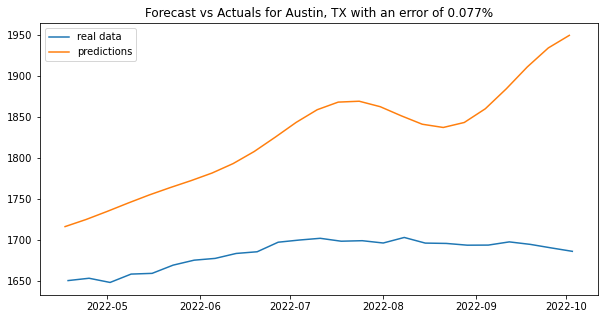

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.373% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 294


  0%|          | 0/115 [00:00<?, ?it/s]

Baltimore, MD


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.48E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.20E-01, min: 2.98E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.06E-01
Epoch[294/294]: 100%|██████████| 294/294 [00:10<00:00, 28.21it/s, SmoothL1Loss=0.00395, MAE=22.8, RMSE=29.9, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.373% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 204.38374876087437
mean_absolute_percentage_error on testing set: 0.09834140664308068
r2_score on testing set: -79.90640761137996
mean_absolute_error on testing set: 204.38374876087437
mean_absolute_percentage_error on testing set: 0.09834140664308068
r2_score on testing set: -79.90640761137996


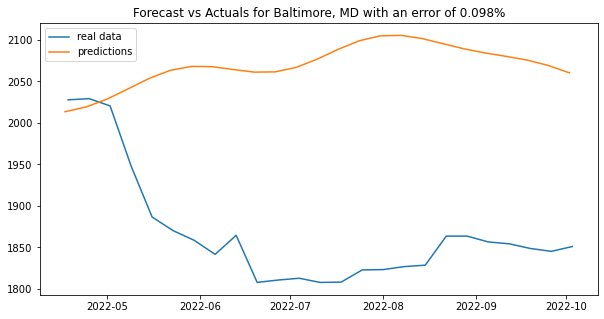

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 287


  0%|          | 0/116 [00:00<?, ?it/s]

Boston, MA


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.18E-02, min: 7.71E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.18E-02, min: 9.23E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.26E-02
Epoch[287/287]: 100%|██████████| 287/287 [00:10<00:00, 28.30it/s, SmoothL1Loss=0.00319, MAE=48.2, RMSE=71.2, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 164.70147860054476
mean_absolute_percentage_error on testing set: 0.051808480725401715
r2_score on testing set: -5.973654508111719
mean_absolute_error on testing set: 164.70147860054476
mean_absolute_percentage_error on testing set: 0.051808480725401715
r2_score on testing set: -5.973654508111719


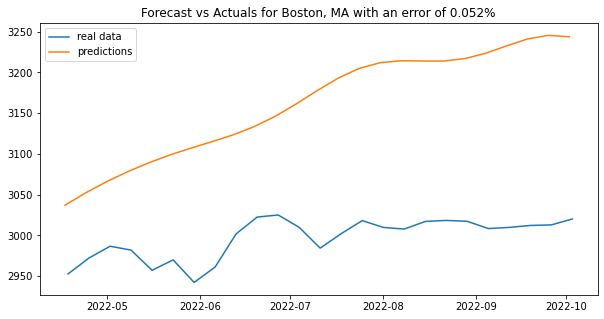

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.584% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 282


  0%|          | 0/116 [00:00<?, ?it/s]

Charleston, SC


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.27E-01, min: 1.11E+00


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.87E-02, min: 1.11E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.04E-01
Epoch[282/282]: 100%|██████████| 282/282 [00:10<00:00, 26.03it/s, SmoothL1Loss=0.00333, MAE=37.4, RMSE=50.6, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.584% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 112.31988303672853
mean_absolute_percentage_error on testing set: 0.060847722802218236
r2_score on testing set: -7.581384323486944
mean_absolute_error on testing set: 112.31988303672853
mean_absolute_percentage_error on testing set: 0.060847722802218236
r2_score on testing set: -7.581384323486944


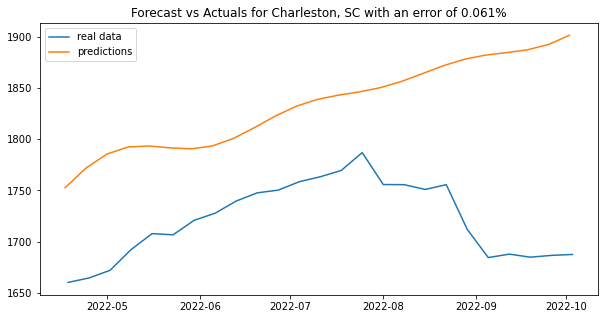

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.489% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 290


  0%|          | 0/115 [00:00<?, ?it/s]

Charlotte, NC


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.34E-02, min: 1.73E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.34E-02, min: 1.73E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.86E-02
Epoch[290/290]: 100%|████████████| 290/290 [00:11<00:00, 25.14it/s, SmoothL1Loss=0.00107, MAE=29, RMSE=39.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.489% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 101.86679827371853
mean_absolute_percentage_error on testing set: 0.05478508707388567
r2_score on testing set: -3.809212299560934
mean_absolute_error on testing set: 101.86679827371853
mean_absolute_percentage_error on testing set: 0.05478508707388567
r2_score on testing set: -3.809212299560934


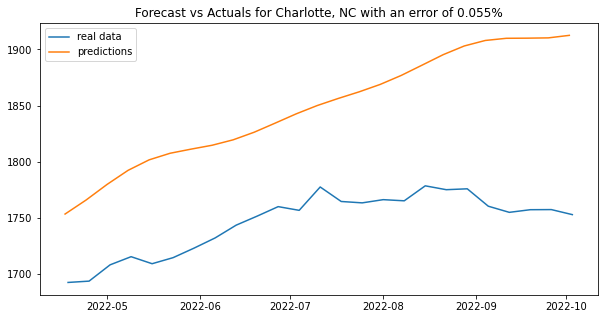

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.545% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Chicago, IL


INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 314


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.52E-02, min: 1.96E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.52E-02, min: 7.07E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.52E-02
Epoch[314/314]: 100%|██████████| 314/314 [00:10<00:00, 30.24it/s, SmoothL1Loss=0.00364, MAE=49.9, RMSE=66.5, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.545% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 42.920833669441436
mean_absolute_percentage_error on testing set: 0.017794623925215858
r2_score on testing set: 0.33094534519560526
mean_absolute_error on testing set: 42.920833669441436
mean_absolute_percentage_error on testing set: 0.017794623925215858
r2_score on testing set: 0.33094534519560526


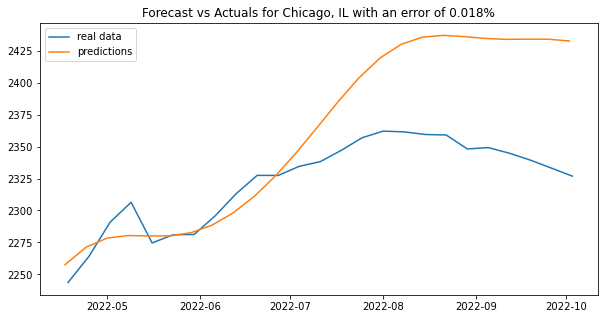

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.722% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 280


  0%|          | 0/116 [00:00<?, ?it/s]

Dallas, TX


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.16E-02, min: 5.38E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.41E-02, min: 5.38E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.26E-02
Epoch[280/280]: 100%|██████████| 280/280 [00:11<00:00, 24.42it/s, SmoothL1Loss=0.00356, MAE=15.8, RMSE=20.3, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.722% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 114.3898994813835
mean_absolute_percentage_error on testing set: 0.06567913583056274
r2_score on testing set: -6.933214480818971
mean_absolute_error on testing set: 114.3898994813835
mean_absolute_percentage_error on testing set: 0.06567913583056274
r2_score on testing set: -6.933214480818971


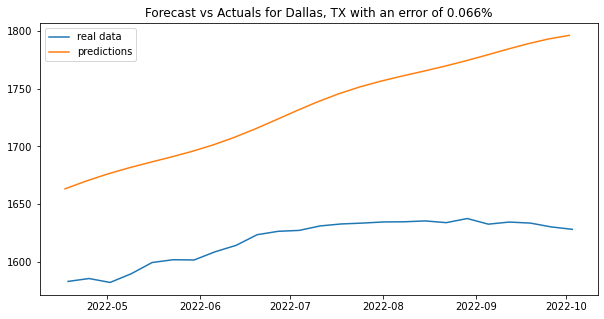

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.698% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 290


  0%|          | 0/115 [00:00<?, ?it/s]

Denver, CO


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.80E-02, min: 1.44E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.80E-02, min: 1.44E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.95E-02
Epoch[290/290]: 100%|██████████| 290/290 [00:11<00:00, 25.42it/s, SmoothL1Loss=0.00268, MAE=34.8, RMSE=58.6, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.698% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 87.85260217136587
mean_absolute_percentage_error on testing set: 0.042483477929054894
r2_score on testing set: -3.19388027376596
mean_absolute_error on testing set: 87.85260217136587
mean_absolute_percentage_error on testing set: 0.042483477929054894
r2_score on testing set: -3.19388027376596


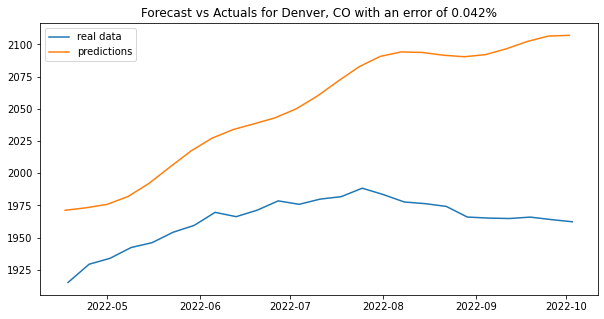

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.738% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 273


  0%|          | 0/117 [00:00<?, ?it/s]

Houston, TX


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 1.15E+00


  0%|          | 0/117 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.42E-02, min: 9.61E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.02E-01
Epoch[273/273]: 100%|██████████| 273/273 [00:12<00:00, 21.23it/s, SmoothL1Loss=0.00632, MAE=29.8, RMSE=43.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.738% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 85.5355048434152
mean_absolute_percentage_error on testing set: 0.05403634746892224
r2_score on testing set: -5.76001908249355
mean_absolute_error on testing set: 85.5355048434152
mean_absolute_percentage_error on testing set: 0.05403634746892224
r2_score on testing set: -5.76001908249355


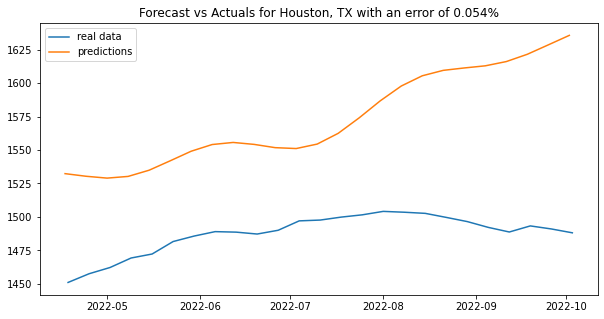

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.308% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16


Jacksonville, FL


INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 307


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.47E+00, min: 1.13E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.43E-02, min: 1.13E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.00E-01
Epoch[307/307]: 100%|██████████| 307/307 [00:11<00:00, 25.72it/s, SmoothL1Loss=0.00189, MAE=22.5, RMSE=28.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.308% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 201.65428980484688
mean_absolute_percentage_error on testing set: 0.10449929966007161
r2_score on testing set: -8.161857555285973
mean_absolute_error on testing set: 201.65428980484688
mean_absolute_percentage_error on testing set: 0.10449929966007161
r2_score on testing set: -8.161857555285973


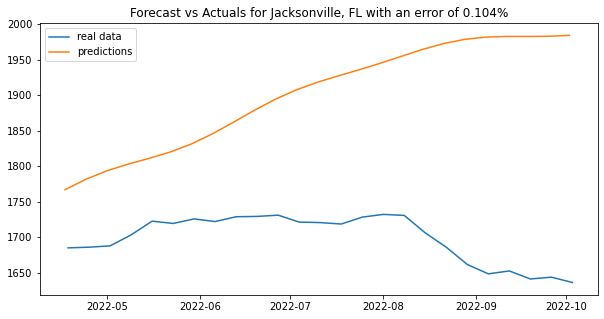

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.351% of the data.


Las Vegas, NV


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 299


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.44E-01, min: 1.53E+00


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.44E-01, min: 1.06E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.27E-01
Epoch[299/299]: 100%|██████████| 299/299 [00:12<00:00, 24.30it/s, SmoothL1Loss=0.00039, MAE=14.1, RMSE=17.2, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.351% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 194.91068739233816
mean_absolute_percentage_error on testing set: 0.10365432515683619
r2_score on testing set: -7.462084011733019
mean_absolute_error on testing set: 194.91068739233816
mean_absolute_percentage_error on testing set: 0.10365432515683619
r2_score on testing set: -7.462084011733019


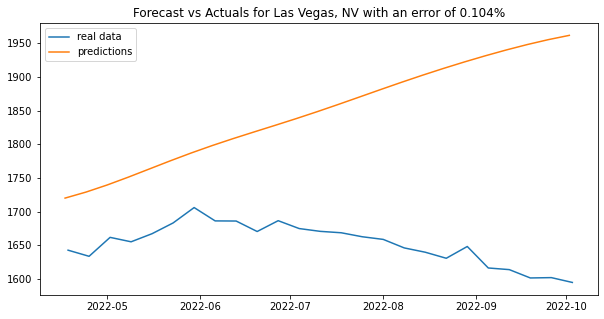

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.474% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 274


  0%|          | 0/117 [00:00<?, ?it/s]

Los Angeles, CA


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.61E-01, min: 1.35E-01


  0%|          | 0/117 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.51E-02, min: 1.61E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.74E-01
Epoch[274/274]: 100%|██████████| 274/274 [00:18<00:00, 15.05it/s, SmoothL1Loss=0.00142, MAE=41.2, RMSE=53.3, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.474% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 175.8351897053417
mean_absolute_percentage_error on testing set: 0.056646418858047234
r2_score on testing set: -4.770120550875637
mean_absolute_error on testing set: 175.8351897053417
mean_absolute_percentage_error on testing set: 0.056646418858047234
r2_score on testing set: -4.770120550875637


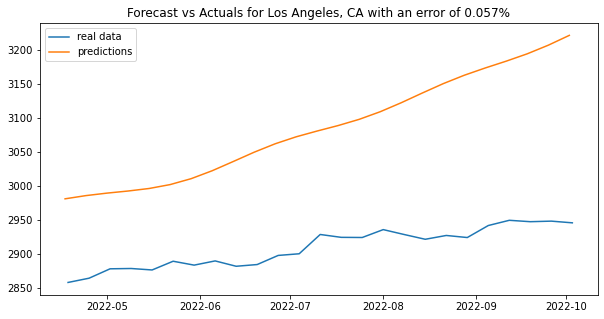

Miami, FL

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.876% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 318


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.52E-02, min: 1.36E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.52E-02, min: 1.36E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.52E-02
Epoch[318/318]: 100%|██████████| 318/318 [00:14<00:00, 21.26it/s, SmoothL1Loss=0.00174, MAE=31.7, RMSE=42.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.876% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 187.684686633007
mean_absolute_percentage_error on testing set: 0.06477450155470102
r2_score on testing set: -2.738781516642527
mean_absolute_error on testing set: 187.684686633007
mean_absolute_percentage_error on testing set: 0.06477450155470102
r2_score on testing set: -2.738781516642527


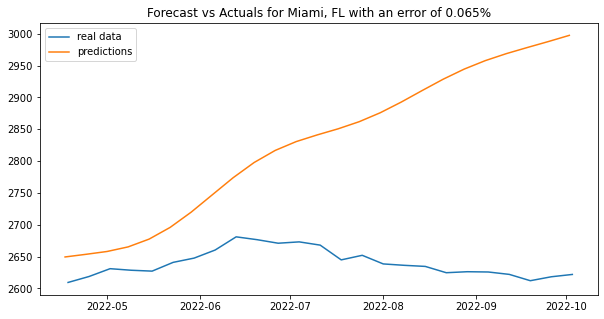

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.55% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 347


  0%|          | 0/112 [00:00<?, ?it/s]

Nashville, TN


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.37E-01, min: 1.13E+00


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.45E-01, min: 7.80E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.88E-01
Epoch[347/347]: 100%|███████████| 347/347 [00:09<00:00, 36.89it/s, SmoothL1Loss=0.0049, MAE=31.6, RMSE=45.6, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.55% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 162.2900290822759
mean_absolute_percentage_error on testing set: 0.07987011427272576
r2_score on testing set: -4.885788823947987
mean_absolute_error on testing set: 162.2900290822759
mean_absolute_percentage_error on testing set: 0.07987011427272576
r2_score on testing set: -4.885788823947987


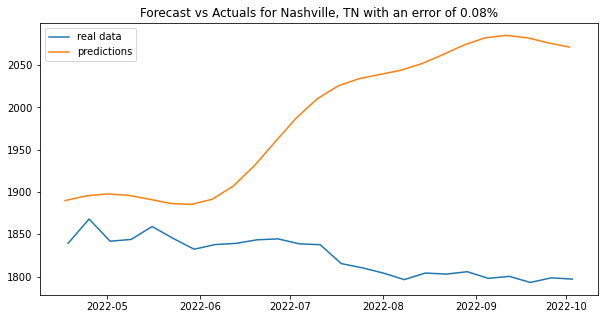

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 303


New York, NY


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.43E-02, min: 1.36E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.52E-02, min: 1.36E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.07E-02
Epoch[303/303]: 100%|████████████| 303/303 [00:10<00:00, 28.90it/s, SmoothL1Loss=0.00843, MAE=131, RMSE=196, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 736.3813031364376
mean_absolute_percentage_error on testing set: 0.15857025288282867
r2_score on testing set: -11.955282152227888
mean_absolute_error on testing set: 736.3813031364376
mean_absolute_percentage_error on testing set: 0.15857025288282867
r2_score on testing set: -11.955282152227888


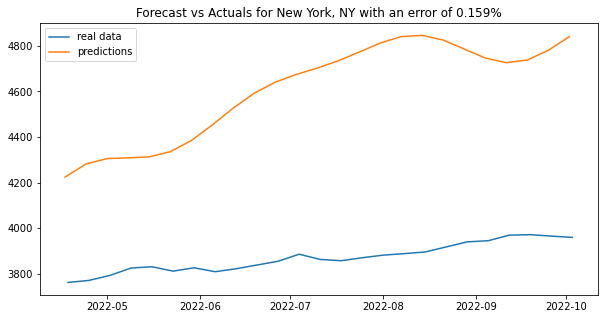

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 305


Orlando, FL


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 1.77E+00


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 1.47E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.08E-01
Epoch[305/305]: 100%|██████████| 305/305 [00:10<00:00, 29.85it/s, SmoothL1Loss=0.00208, MAE=34.4, RMSE=42.7, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 167.50881270250358
mean_absolute_percentage_error on testing set: 0.07813421744775642
r2_score on testing set: -5.214046988357405
mean_absolute_error on testing set: 167.50881270250358
mean_absolute_percentage_error on testing set: 0.07813421744775642
r2_score on testing set: -5.214046988357405


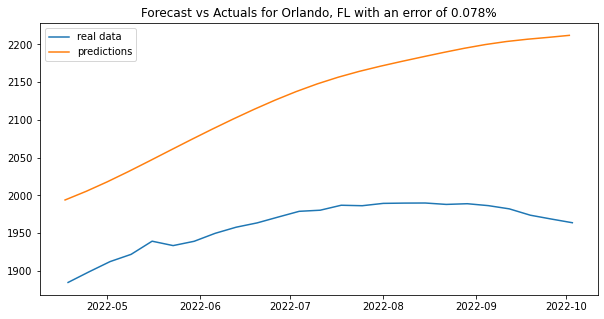

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.738% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 273


Phoenix, AZ


  0%|          | 0/117 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.51E-02, min: 2.30E-01


  0%|          | 0/117 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.42E-02, min: 3.93E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.04E-02
Epoch[273/273]: 100%|████████████| 273/273 [00:11<00:00, 24.48it/s, SmoothL1Loss=0.001, MAE=21.9, RMSE=28.4, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.738% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 178.84572098738508
mean_absolute_percentage_error on testing set: 0.09282204623900707
r2_score on testing set: -8.464146984729645
mean_absolute_error on testing set: 178.84572098738508
mean_absolute_percentage_error on testing set: 0.09282204623900707
r2_score on testing set: -8.464146984729645


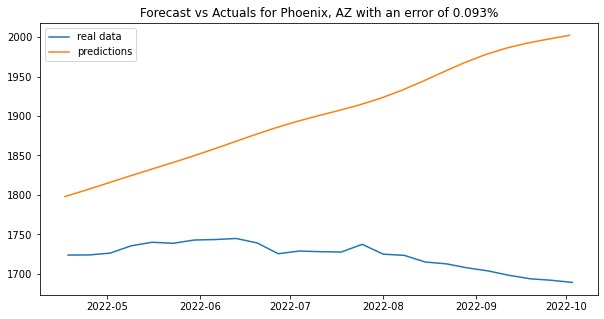

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.448% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 279


Portland, OR


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.31E-02, min: 8.87E-02


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.16E-02, min: 1.27E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.06E-02
Epoch[279/279]: 100%|██████████| 279/279 [00:10<00:00, 25.44it/s, SmoothL1Loss=0.00112, MAE=28.5, RMSE=40.2, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.448% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 51.85601460532893
mean_absolute_percentage_error on testing set: 0.0286266985663602
r2_score on testing set: -0.721455994978154
mean_absolute_error on testing set: 51.85601460532893
mean_absolute_percentage_error on testing set: 0.0286266985663602
r2_score on testing set: -0.721455994978154


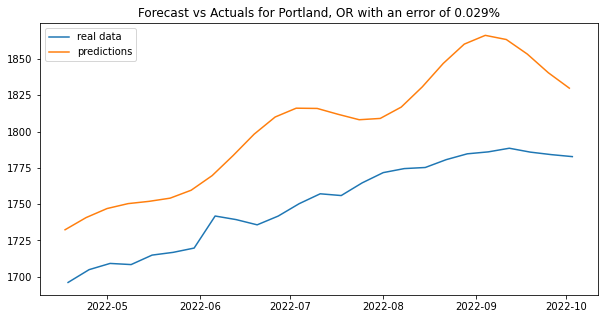

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 302


Raleigh, NC


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.83E-02, min: 1.20E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.83E-02, min: 1.20E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.16E-02
Epoch[302/302]: 100%|██████████| 302/302 [00:10<00:00, 29.66it/s, SmoothL1Loss=0.00452, MAE=39.4, RMSE=57.4, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 94.36225561474744
mean_absolute_percentage_error on testing set: 0.05168601813073681
r2_score on testing set: -1.253796512779033
mean_absolute_error on testing set: 94.36225561474744
mean_absolute_percentage_error on testing set: 0.05168601813073681
r2_score on testing set: -1.253796512779033


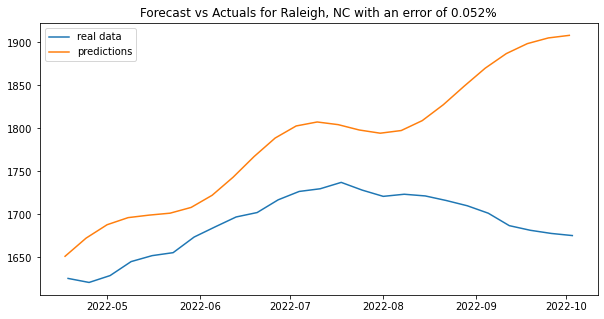

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.621% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 320


  0%|          | 0/114 [00:00<?, ?it/s]

Riverside, CA


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.36E-01, min: 2.55E+00


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.36E-01, min: 2.13E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.23E-01
Epoch[320/320]: 100%|███████████| 320/320 [00:09<00:00, 33.21it/s, SmoothL1Loss=0.000432, MAE=19, RMSE=26.9, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.621% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 107.5465369507455
mean_absolute_percentage_error on testing set: 0.04028253747193902
r2_score on testing set: -2.155238731449275
mean_absolute_error on testing set: 107.5465369507455
mean_absolute_percentage_error on testing set: 0.04028253747193902
r2_score on testing set: -2.155238731449275


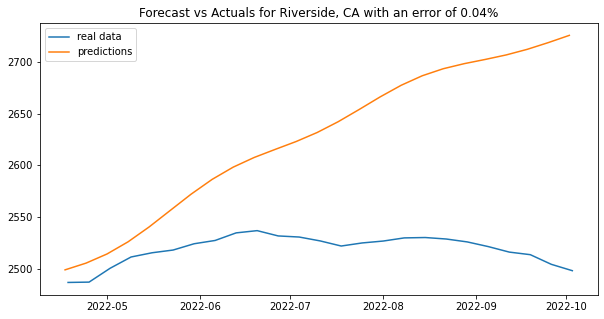

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.435% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 282


San Antonio, TX


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.18E-02, min: 9.23E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.87E-02, min: 2.18E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.19E-02
Epoch[282/282]: 100%|██████████| 282/282 [00:11<00:00, 24.72it/s, SmoothL1Loss=0.00529, MAE=34.5, RMSE=49.7, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.435% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 84.01549389696629
mean_absolute_percentage_error on testing set: 0.06116831247056519
r2_score on testing set: -6.633476778501454
mean_absolute_error on testing set: 84.01549389696629
mean_absolute_percentage_error on testing set: 0.06116831247056519
r2_score on testing set: -6.633476778501454


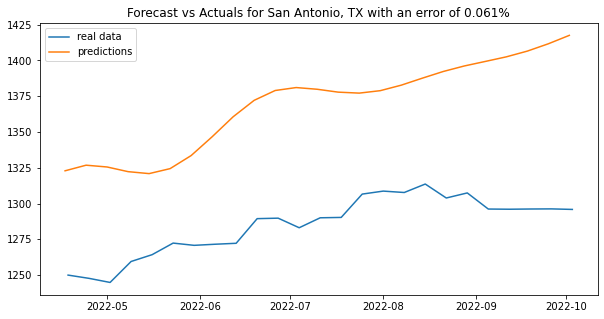

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.649% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 304


San Diego, CA


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 2.83E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 2.35E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.08E-01
Epoch[304/304]: 100%|█████████| 304/304 [00:10<00:00, 30.12it/s, SmoothL1Loss=0.000547, MAE=27.7, RMSE=35.9, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.649% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 52.970551796329616
mean_absolute_percentage_error on testing set: 0.017848796118423094
r2_score on testing set: 0.41518590118449816
mean_absolute_error on testing set: 52.970551796329616
mean_absolute_percentage_error on testing set: 0.017848796118423094
r2_score on testing set: 0.41518590118449816


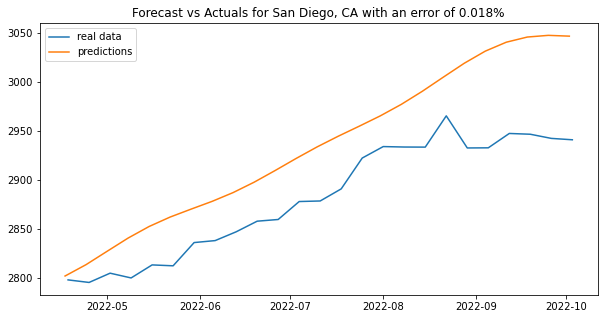

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.13% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 285


San Francisco, CA


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E-01, min: 2.27E+00


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E-01, min: 2.61E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.04E-01
Epoch[285/285]: 100%|███████████| 285/285 [00:10<00:00, 26.09it/s, SmoothL1Loss=0.00408, MAE=97.7, RMSE=142, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.13% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 199.05014660863992
mean_absolute_percentage_error on testing set: 0.06139618901276401
r2_score on testing set: -8.301103393207946
mean_absolute_error on testing set: 199.05014660863992
mean_absolute_percentage_error on testing set: 0.06139618901276401
r2_score on testing set: -8.301103393207946


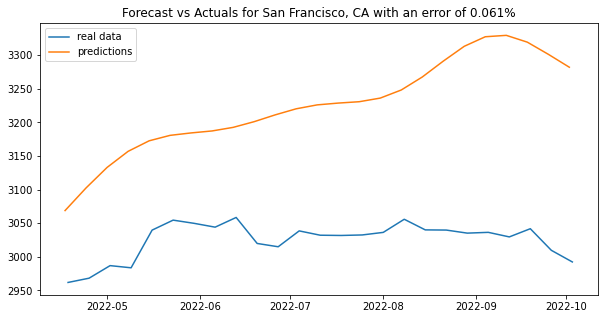

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.666% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 303


  0%|          | 0/115 [00:00<?, ?it/s]

San Jose, CA


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.80E-02, min: 6.16E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.83E-02, min: 1.20E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.54E-02
Epoch[303/303]: 100%|███████████| 303/303 [00:10<00:00, 28.15it/s, SmoothL1Loss=0.0017, MAE=32.8, RMSE=43.4, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.666% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 27.69736201323765
mean_absolute_percentage_error on testing set: 0.008378531435487278
r2_score on testing set: 0.7990180840769021
mean_absolute_error on testing set: 27.69736201323765
mean_absolute_percentage_error on testing set: 0.008378531435487278
r2_score on testing set: 0.7990180840769021


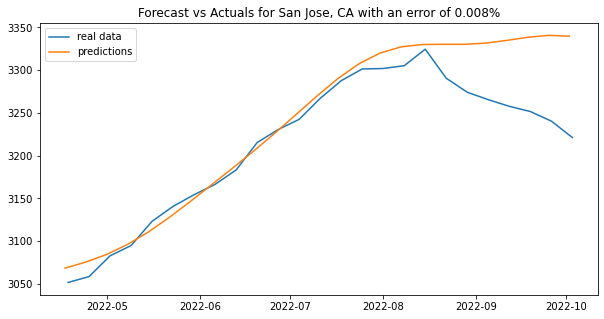

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.029% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 298


  0%|          | 0/115 [00:00<?, ?it/s]

Seattle, WA


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.95E-02, min: 2.48E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.95E-02, min: 1.27E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.85E-02
Epoch[298/298]: 100%|█████████| 298/298 [00:10<00:00, 28.72it/s, SmoothL1Loss=0.000567, MAE=32.2, RMSE=42.2, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.029% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 210.80830759044287
mean_absolute_percentage_error on testing set: 0.08735377660025931
r2_score on testing set: -8.478570346754674
mean_absolute_error on testing set: 210.80830759044287
mean_absolute_percentage_error on testing set: 0.08735377660025931
r2_score on testing set: -8.478570346754674


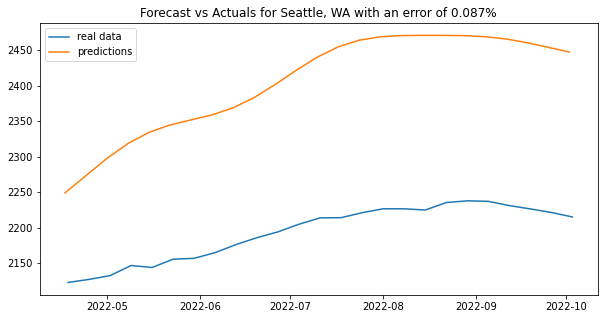

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.68% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 301


  0%|          | 0/115 [00:00<?, ?it/s]

Tampa, FL


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.44E-01, min: 1.83E+00


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.44E-01, min: 1.06E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.27E-01
Epoch[301/301]: 100%|██████████| 301/301 [00:09<00:00, 30.26it/s, SmoothL1Loss=0.00136, MAE=28.3, RMSE=35.8, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.68% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 187.8491988899056
mean_absolute_percentage_error on testing set: 0.08440603634713424
r2_score on testing set: -4.427687767825375
mean_absolute_error on testing set: 187.8491988899056
mean_absolute_percentage_error on testing set: 0.08440603634713424
r2_score on testing set: -4.427687767825375


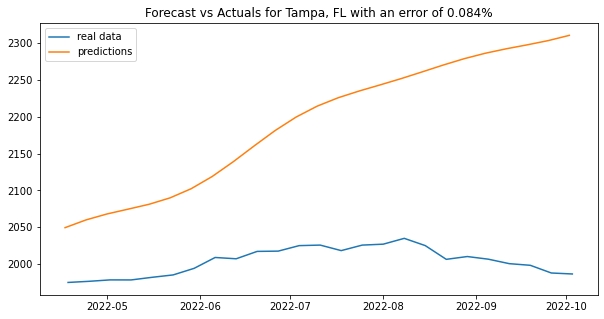

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 294


  0%|          | 0/115 [00:00<?, ?it/s]

Washington, DC


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 4.28E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.34E-02, min: 1.83E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.41E-02
Epoch[294/294]: 100%|██████████| 294/294 [00:09<00:00, 29.44it/s, SmoothL1Loss=0.00617, MAE=54.6, RMSE=75.3, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 104.52694397098858
mean_absolute_percentage_error on testing set: 0.04578597363028594
r2_score on testing set: -5.452145515815701
mean_absolute_error on testing set: 104.52694397098858
mean_absolute_percentage_error on testing set: 0.04578597363028594
r2_score on testing set: -5.452145515815701


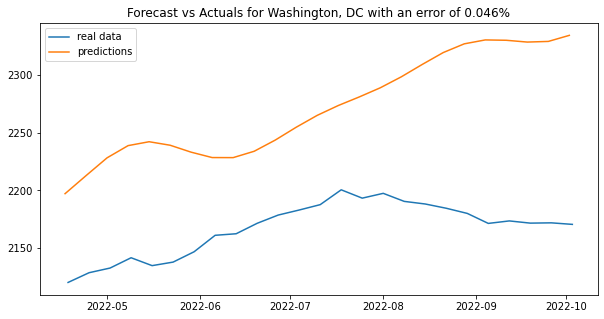

In [21]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
    
        ## experimenting with a dataset
        prediction_period = 25
        algorithm_name = 'Neural Prophet Model'

        results = NeuralProphetModel(algorithm_name, prediction_period)
        print(unique_val)

        df_train, df_test = results.transformation(subset, 'WEEK_START', 'NER_T4')        
        
        results.fit_model(df_train)
        predictions = results.predict(df_train)
        results.evaluation(df_test, predictions)
        results.plot(df_test, predictions, unique_val)

**Extracting the data into a df**

In [22]:
msa_data = pd.read_csv('msa_data.csv')
msa_data_lst = list(msa_data['MSA'])

subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER_T4').reset_index()

In [23]:
column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

df_neural_prophet = pd.DataFrame(columns = column_names)
df_neural_prophet

,Model,Time,MSA,Actuals,Predictions,MAPE score


In [24]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
    
    
        column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

        df = pd.DataFrame(columns = column_names)
        ## experimenting with a dataset
        prediction_period = 25
        algorithm_name = 'Neural Prophet Model'

        results = NeuralProphetModel(algorithm_name, prediction_period)
        
        
        df_train, df_test = results.transformation(subset, 'WEEK_START', 'NER_T4')
        
        
        results.fit_model(df_train)
        predictions = results.predict(df_train)
        mape_score = results.evaluation(df_test, predictions)
        #print(predictions['yhat1'])
        df['Actuals'] =  df_test['y']
        df['Time'] =  df_test['ds']
        df['Predictions'] =  list(predictions['yhat1'])
        df['MAPE score'] =  mape_score
        df['Model'] =  algorithm_name
        df['MSA'] =  unique_val
        #print(df)

        #results.evaluation(df_test, predictions)
        df_neural_prophet = df_neural_prophet.append(df, ignore_index=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.201% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 313


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 8.50E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 1.23E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.60E-02
Epoch[313/313]: 100%|██████████| 313/313 [00:10<00:00, 28.62it/s, SmoothL1Loss=0.00242, MAE=51.4, RMSE=69.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.201% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.038% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 192.6681454138416
mean_absolute_percentage_error on testing set: 0.09557935485364563
r2_score on testing set: -9.401273144317411


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.20E-01, min: 2.98E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.20E-01, min: 2.48E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.13E-01
Epoch[297/297]: 100%|██████████| 297/297 [00:11<00:00, 25.67it/s, SmoothL1Loss=0.00298, MAE=47.8, RMSE=71.6, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.038% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.373% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 142.93930191248876
mean_absolute_percentage_error on testing set: 0.07735976358279192
r2_score on testing set: -4.467245935696984


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.34E-02, min: 1.27E+00


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.34E-02, min: 1.27E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.86E-02
Epoch[294/294]: 100%|██████████| 294/294 [00:11<00:00, 26.11it/s, SmoothL1Loss=0.00417, MAE=23.5, RMSE=30.9, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.373% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.941% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/116 [00:00<?, ?it/s]

mean_absolute_error on testing set: 201.30059934681188
mean_absolute_percentage_error on testing set: 0.09702972225247775
r2_score on testing set: -93.30415034160373


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.82E-01, min: 1.90E+00


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.82E-01, min: 3.26E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.49E-01
Epoch[287/287]: 100%|██████████| 287/287 [00:13<00:00, 21.70it/s, SmoothL1Loss=0.00317, MAE=47.6, RMSE=73.5, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 97.941% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.584% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/116 [00:00<?, ?it/s]

mean_absolute_error on testing set: 163.33113680366975
mean_absolute_percentage_error on testing set: 0.05137369683023833
r2_score on testing set: -5.485594420485332


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.41E-02, min: 1.52E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E-01, min: 3.75E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.23E-02
Epoch[282/282]: 100%|█████████████| 282/282 [00:19<00:00, 14.49it/s, SmoothL1Loss=0.0033, MAE=38, RMSE=50.5, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.584% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.489% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 112.64827170860353
mean_absolute_percentage_error on testing set: 0.06099640572293612
r2_score on testing set: -7.363334062980032


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.86E-01, min: 1.20E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.83E-02, min: 1.20E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.62E-01
Epoch[290/290]: 100%|██████████| 290/290 [00:11<00:00, 24.38it/s, SmoothL1Loss=0.00105, MAE=28.7, RMSE=39.6, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.489% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.545% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 99.79007952371852
mean_absolute_percentage_error on testing set: 0.05372537360716114
r2_score on testing set: -3.690642190351916


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.52E-02, min: 1.63E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.52E-02, min: 1.63E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.52E-02
Epoch[314/314]: 100%|██████████| 314/314 [00:10<00:00, 28.56it/s, SmoothL1Loss=0.00372, MAE=50.3, RMSE=68.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.545% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.722% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/116 [00:00<?, ?it/s]

mean_absolute_error on testing set: 49.67323830074865
mean_absolute_percentage_error on testing set: 0.020533550749076545
r2_score on testing set: 0.11134531628030275


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.41E-02, min: 1.90E+00


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.41E-02, min: 2.72E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.19E-02
Epoch[280/280]: 100%|██████████| 280/280 [00:18<00:00, 15.19it/s, SmoothL1Loss=0.00357, MAE=15.8, RMSE=20.5, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.722% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.698% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 114.06781452044599
mean_absolute_percentage_error on testing set: 0.06550628625737882
r2_score on testing set: -6.908585681711722


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.20E-01, min: 4.28E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.20E-01, min: 2.20E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.13E-01
Epoch[290/290]: 100%|███████████| 290/290 [00:16<00:00, 17.42it/s, SmoothL1Loss=0.0024, MAE=33.1, RMSE=54.2, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.698% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.738% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/117 [00:00<?, ?it/s]

mean_absolute_error on testing set: 79.84196740574085
mean_absolute_percentage_error on testing set: 0.038736609634190136
r2_score on testing set: -2.698539206270519


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.42E-02, min: 3.93E-01


  0%|          | 0/117 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.35E-01, min: 3.29E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.08E-01
Epoch[273/273]: 100%|██████████| 273/273 [00:14<00:00, 19.07it/s, SmoothL1Loss=0.00632, MAE=29.8, RMSE=43.6, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.738% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.308% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 85.9012519137277
mean_absolute_percentage_error on testing set: 0.05425486682021305
r2_score on testing set: -5.78441170745067


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.52E-02, min: 1.36E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.23E+00, min: 1.36E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.00E-01
Epoch[307/307]: 100%|██████████| 307/307 [00:18<00:00, 16.77it/s, SmoothL1Loss=0.00194, MAE=22.8, RMSE=28.4, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.308% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.351% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 200.0924392189094
mean_absolute_percentage_error on testing set: 0.1036409316688612
r2_score on testing set: -7.601122823665747


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.98E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 1.53E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.00E-01
Epoch[299/299]: 100%|█████████| 299/299 [00:13<00:00, 21.97it/s, SmoothL1Loss=0.000353, MAE=13.2, RMSE=16.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.351% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.474% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/117 [00:00<?, ?it/s]

mean_absolute_error on testing set: 193.23379774390065
mean_absolute_percentage_error on testing set: 0.10274384003456116
r2_score on testing set: -6.9746099517927345


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.59E-02, min: 9.61E-01


  0%|          | 0/117 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.42E-02, min: 1.93E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.53E-02
Epoch[274/274]: 100%|██████████| 274/274 [00:13<00:00, 19.80it/s, SmoothL1Loss=0.00142, MAE=41.2, RMSE=52.8, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.474% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.876% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 176.1483342365917
mean_absolute_percentage_error on testing set: 0.056743073446506934
r2_score on testing set: -4.79662140151037


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 2.35E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 2.35E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.60E-02
Epoch[318/318]: 100%|██████████| 318/318 [00:12<00:00, 26.00it/s, SmoothL1Loss=0.00174, MAE=31.6, RMSE=41.5, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.876% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.55% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/112 [00:00<?, ?it/s]

mean_absolute_error on testing set: 186.989969836132
mean_absolute_percentage_error on testing set: 0.06452010211570665
r2_score on testing set: -2.679758147995288


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.30E-02, min: 3.07E-01


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 3.07E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.40E-02
Epoch[347/347]: 100%|██████████| 347/347 [00:10<00:00, 32.60it/s, SmoothL1Loss=0.00489, MAE=31.5, RMSE=44.6, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.55% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.993% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 176.20023416040087
mean_absolute_percentage_error on testing set: 0.0861555457918638
r2_score on testing set: -5.235505098682358


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.36E-01, min: 1.77E+00


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 3.07E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.15E-01
Epoch[303/303]: 100%|████████████| 303/303 [00:11<00:00, 26.12it/s, SmoothL1Loss=0.00833, MAE=129, RMSE=198, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.983% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 745.4682953239376
mean_absolute_percentage_error on testing set: 0.1601953611735183
r2_score on testing set: -11.982365302455495


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 1.23E+00


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 1.02E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.08E-01
Epoch[305/305]: 100%|██████████| 305/305 [00:14<00:00, 20.67it/s, SmoothL1Loss=0.00208, MAE=34.4, RMSE=42.5, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.738% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/117 [00:00<?, ?it/s]

mean_absolute_error on testing set: 169.56263594469107
mean_absolute_percentage_error on testing set: 0.07902415011857591
r2_score on testing set: -5.353848926979193


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 2.75E-01


  0%|          | 0/117 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.13E-01, min: 9.61E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.08E-01
Epoch[273/273]: 100%|██████████| 273/273 [00:23<00:00, 11.45it/s, SmoothL1Loss=0.00102, MAE=22.1, RMSE=28.8, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.738% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.448% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/116 [00:00<?, ?it/s]

mean_absolute_error on testing set: 179.22463212019755
mean_absolute_percentage_error on testing set: 0.09298307208748557
r2_score on testing set: -8.350701497928533


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.18E-01, min: 5.38E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.52E-01, min: 3.13E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.49E-01
Epoch[279/279]: 100%|█████████████| 279/279 [00:20<00:00, 13.79it/s, SmoothL1Loss=0.0011, MAE=28, RMSE=39.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.448% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.667% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 49.93426655845393
mean_absolute_percentage_error on testing set: 0.02758062267378754
r2_score on testing set: -0.5747234732281703


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.20E-01, min: 3.57E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.20E-01, min: 1.53E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.13E-01
Epoch[302/302]: 100%|████████████| 302/302 [00:13<00:00, 21.67it/s, SmoothL1Loss=0.00455, MAE=39.4, RMSE=57, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.621% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 94.06281713818494
mean_absolute_percentage_error on testing set: 0.05151373279414385
r2_score on testing set: -1.2304542174125066


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.41E-02, min: 1.47E+00


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.83E-02, min: 1.77E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.03E-02
Epoch[320/320]: 100%|██████████| 320/320 [00:13<00:00, 24.25it/s, SmoothL1Loss=0.00043, MAE=18.9, RMSE=26.6, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.621% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.435% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/116 [00:00<?, ?it/s]

mean_absolute_error on testing set: 103.4088514038705
mean_absolute_percentage_error on testing set: 0.038731714532572556
r2_score on testing set: -1.8898661108790749


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.87E-02, min: 1.82E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.82E-01, min: 5.38E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.17E-01
Epoch[282/282]: 100%|██████████| 282/282 [00:14<00:00, 19.45it/s, SmoothL1Loss=0.00527, MAE=34.7, RMSE=50.3, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.435% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.649% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/114 [00:00<?, ?it/s]

mean_absolute_error on testing set: 82.20866772509129
mean_absolute_percentage_error on testing set: 0.05994067771311153
r2_score on testing set: -6.607625268026922


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.63E-01, min: 4.90E-01


  0%|          | 0/114 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.36E-01, min: 3.40E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.30E-01
Epoch[304/304]: 100%|█████████| 304/304 [00:14<00:00, 21.33it/s, SmoothL1Loss=0.000505, MAE=26.9, RMSE=33.4, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.649% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.13% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/116 [00:00<?, ?it/s]

mean_absolute_error on testing set: 53.92568851507962
mean_absolute_percentage_error on testing set: 0.01815961155286818
r2_score on testing set: 0.40529851556503504


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E-01, min: 7.71E-01


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.27E-01, min: 6.44E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.11E-01
Epoch[285/285]: 100%|█████████████| 285/285 [00:14<00:00, 20.04it/s, SmoothL1Loss=0.00403, MAE=98, RMSE=145, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.13% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.666% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 194.42154309301492
mean_absolute_percentage_error on testing set: 0.06007258167668352
r2_score on testing set: -8.521630104268354


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E+00, min: 6.95E-02


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E+00, min: 1.00E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.83E-01
Epoch[303/303]: 100%|██████████| 303/303 [00:13<00:00, 22.52it/s, SmoothL1Loss=0.00168, MAE=32.3, RMSE=43.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.666% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.029% of the data.
INFO - (NP.df_utils._infer_frequency)

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 27.879145488622417
mean_absolute_percentage_error on testing set: 0.008467568092544328
r2_score on testing set: 0.8152930281868592


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.80E-02, min: 1.20E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.80E-02, min: 1.20E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.95E-02
Epoch[298/298]: 100%|█████████| 298/298 [00:14<00:00, 20.93it/s, SmoothL1Loss=0.000585, MAE=32.5, RMSE=43.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.029% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.68% of the data.
INFO - (NP.df_utils._infer_frequency) 

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 212.98930368419286
mean_absolute_percentage_error on testing set: 0.08815196140712697
r2_score on testing set: -8.197034350728341


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.44E-01, min: 3.57E-01


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.44E-01, min: 1.83E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.27E-01
Epoch[301/301]: 100%|██████████| 301/301 [00:15<00:00, 19.14it/s, SmoothL1Loss=0.00143, MAE=28.9, RMSE=36.9, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.68% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.75% of the data.
INFO - (NP.df_utils._infer_frequency) -

  0%|          | 0/115 [00:00<?, ?it/s]

mean_absolute_error on testing set: 186.6147164680306
mean_absolute_percentage_error on testing set: 0.08391490028536706
r2_score on testing set: -4.455160348984576


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.95E-02, min: 4.03E-02


  0%|          | 0/115 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.28E-01, min: 4.83E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.41E-02
Epoch[294/294]: 100%|██████████| 294/294 [00:17<00:00, 17.13it/s, SmoothL1Loss=0.00608, MAE=54.2, RMSE=73.9, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - w


mean_absolute_error on testing set: 103.16177795536358
mean_absolute_percentage_error on testing set: 0.04521172235003716
r2_score on testing set: -5.276122575969083


In [25]:
df_neural_prophet['Hash Column'] = df_neural_prophet['MSA'] + df_neural_prophet['Time'].astype(str)

In [26]:
df_neural_prophet

,Model,Time,MSA,Actuals,Predictions,MAPE score,Hash Column
0,Neural Prophet Model,2022-04-18,"Atlanta, GA",1790.830447,1901.719116,0.095579,"Atlanta, GA2022-04-18"
1,Neural Prophet Model,2022-04-25,"Atlanta, GA",1792.420025,1909.367065,0.095579,"Atlanta, GA2022-04-25"
2,Neural Prophet Model,2022-05-02,"Atlanta, GA",1799.222625,1909.789795,0.095579,"Atlanta, GA2022-05-02"
3,Neural Prophet Model,2022-05-09,"Atlanta, GA",1792.786981,1906.227783,0.095579,"Atlanta, GA2022-05-09"
4,Neural Prophet Model,2022-05-16,"Atlanta, GA",1798.340909,1904.417603,0.095579,"Atlanta, GA2022-05-16"
...,...,...,...,...,...,...,...
695,Neural Prophet Model,2022-09-05,"Washington, DC",2171.473456,2328.788574,0.045212,"Washington, DC2022-09-05"
696,Neural Prophet Model,2022-09-12,"Washington, DC",2173.625605,2327.917236,0.045212,"Washington, DC2022-09-12"
697,Neural Prophet Model,2022-09-19,"Washington, DC",2171.713568,2326.169678,0.045212,"Washington, DC2022-09-19"
698,Neural Prophet Model,2022-09-26,"Washington, DC",2171.963422,2327.053955,0.045212,"Washington, DC2022-09-26"


In [27]:
df_neural_prophet.to_csv("df_neural_prophet_msa_level_SAME_STORE.csv")